# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [3]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py

# Data manipulation
import numpy as np
from scipy.special import erf
from scipy.integrate import quad
from scipy.signal import savgol_filter

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as mcolors
import matplotlib.colors as colors

# From alens_analysis.py
import alens_analysis as aa
from alens_analysis.colormaps import register_cmaps
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
from alens_analysis import cluster_analysis as cla

# Locations
ws_path = Path('/home/alamson/DATA/Chromatin/')
mnt_path = Path.home() / 'projects/DATA/Chromatin/'
ceph_path = Path.home() / 'ceph/DATA/Chromatin/'

### Style settings

In [4]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)

register_cmaps()
plt.rcParams['image.cmap'] = 'YlOrRd'
#plt.rcParams['image.cmap'] = 'emct8'
#plt.rcParams['image.cmap'] = 'warm'
#plt.rcParams['image.cmap'] = 'twilight'
#plt.rcParams['image.cmap'] = 'coolwarm'
#plt.rcParams['image.cmap'] = 'RdYlBu_r'
        

# Functions

In [3]:
def get_sd_scan_cluster_num_and_bead_lst(param_dir_path):   
    seed_paths = [path for path in param_dir_path.glob('**/s*') if path.is_dir()]
    assert seed_paths
    sd_cluster_num_lst = []
    sd_total_bead_lst = []
    
    for sp in seed_paths:
        time_arr, com_arr, t_grp_clusters = cla.collect_cluster_data(sp)
        trees = cla.make_cluster_trees(t_grp_clusters)
        num_cluster_arr = np.zeros(time_arr.shape)
        num_cluster_beads_arr = np.zeros(time_arr.shape)
        for tree in trees:
            for clust in tree.clusters:
                t_idx = np.where(time_arr == clust.time)
                num_cluster_arr[t_idx] += 1
                num_cluster_beads_arr[t_idx] += len(clust.part_ids)
            
        sd_cluster_num_lst += [num_cluster_arr]
        sd_total_bead_lst += [num_cluster_beads_arr]
    # TODO Pad this array with empty values
    return time_arr, sd_cluster_num_lst, sd_total_bead_lst

# Single seeds

In [12]:
data_path = (ceph_path /"22-08-12_aLc1_scan8.12_line800_sticky55nm_ko.1-300_5umconf/simulations/kod300/s1")

# Length of chain and time to look at
ss_ind = 1
end_ind = None
start_bead = 0
end_bead = None

# Get bead position information
with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    print(time_arr.shape)
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

# Get cluster information
h5_clust_file = next(data_path.glob('analysis/cluster*.h5')) 
with h5py.File(h5_clust_file, 'r') as h5_data:
    cluster_grp = h5_data['clusters']
    time_arr = h5_data['time'][...]
    time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
    clusters = []
    for tg in time_grp_list:
        clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]

root_clusters = cla.find_descendants(clusters, thresh=.1, nskip=20)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree]

# for tree in trees:
for tree in filter(lambda x: len(x.clusters) > 20, trees):
    tree.prune_branches()

    

(2401,)
Nummber of roots to delete 7
Nummber of roots to delete 3
Nummber of roots to delete 13
Nummber of roots to delete 1
Nummber of roots to delete 1
Nummber of roots to delete 23
Nummber of roots to delete 11


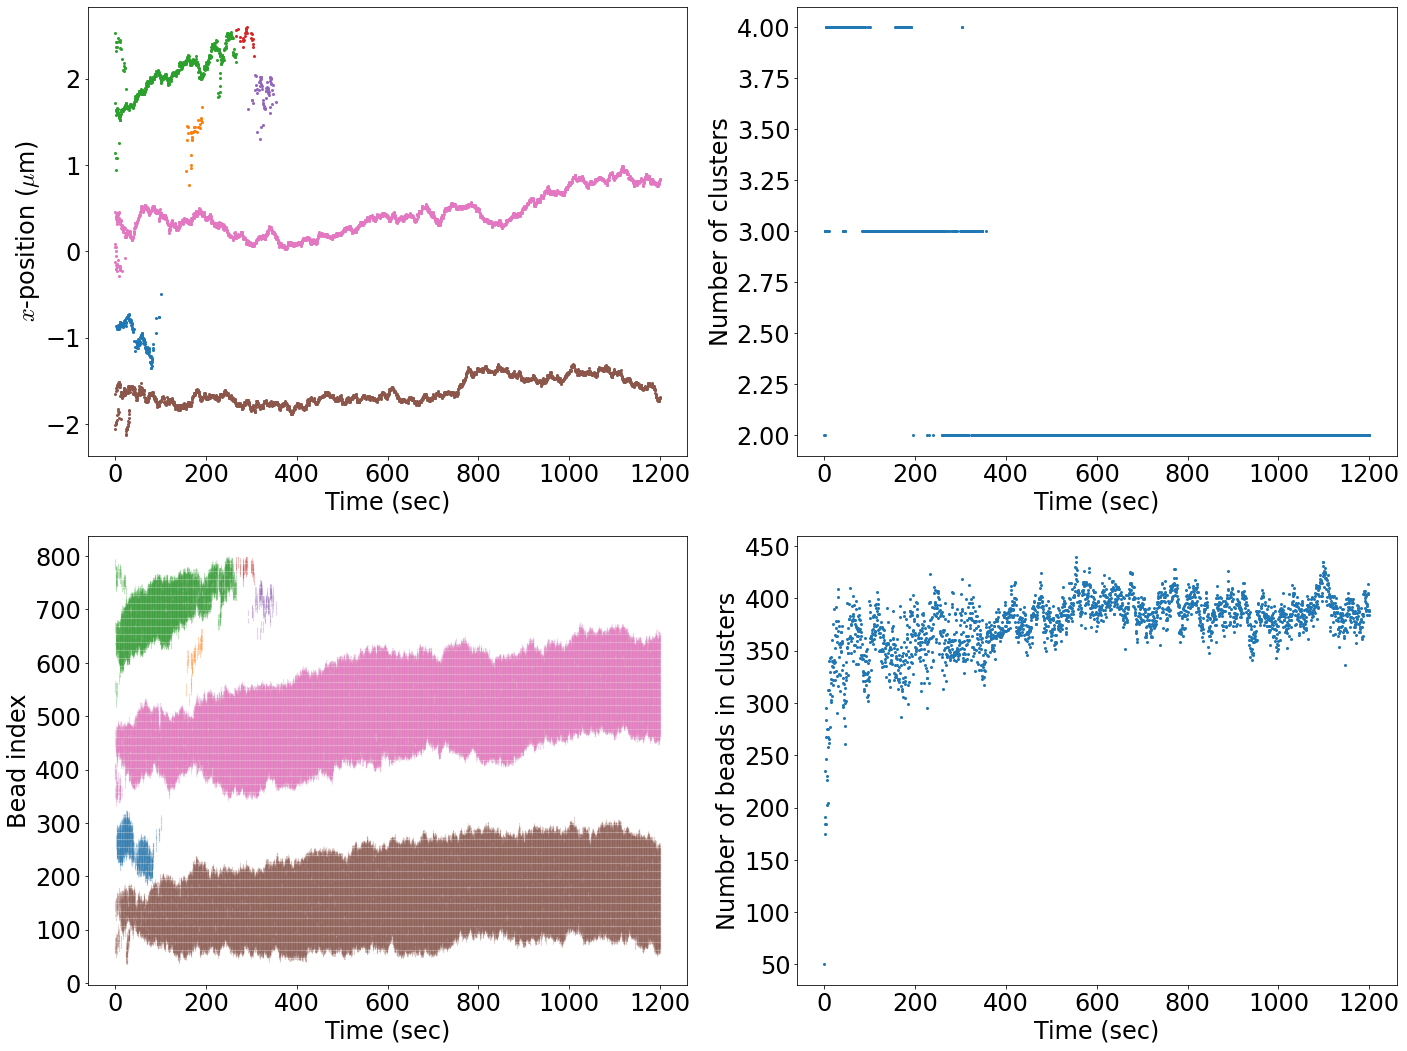

In [13]:
num_cluster_arr = np.zeros(time_arr.shape)
num_cluster_beads_arr = np.zeros(time_arr.shape)

fig, axarr = plt.subplots(2,2, figsize=(20, 15))
for tree in trees:
    if len(tree.clusters) < 20:
        continue
    time_lst = []
    flat_time_lst = []
    clust_ids = []
    clust_centers = []
    for clust in tree.clusters:

        t_idx = np.where(time_arr == clust.time)
        if clust.time not in time_lst:
            num_cluster_arr[t_idx] += 1
        num_cluster_beads_arr[t_idx] += len(clust.part_ids)

        time_lst += [clust.time]
        clust_centers += [clust.center]

        flat_time_lst += [clust.time]*len(clust.part_ids)
        clust_ids += clust.part_ids.tolist()
    _ = axarr[0,0].scatter(time_lst, np.array(clust_centers)[:,0])
    _ = axarr[1,0].scatter(flat_time_lst, clust_ids, s= .01, marker='.')

_ = axarr[0,1].scatter(time_arr, num_cluster_arr)
#axarr[1,0].scatter(flat_time_arr, flat_clust_ind_arr)
_ = axarr[1,1].scatter(time_arr, num_cluster_beads_arr)

_ = axarr[0,0].set_ylabel('$x$-position ($\mu$m)')
_ = axarr[0,1].set_ylabel('Number of clusters')
_ = axarr[1,0].set_ylabel('Bead index')
_ = axarr[1,1].set_ylabel('Number of beads in clusters')
for ax in axarr.flatten():
    _ = ax.set_xlabel('Time (sec)')
fig.tight_layout()

In [10]:
data_path = (ceph_path /"22-08-12_aLc1_scan8.12_line800_sticky55nm_ko.1-300_5umconf/simulations/kod300/s2")

# Length of chain and time to look at
ss_ind = 1
end_ind = None
start_bead = 0
end_bead = None

# Get bead position information
with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    print(time_arr.shape)
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

# Get cluster information
h5_clust_file = next(data_path.glob('analysis/cluster*.h5')) 
with h5py.File(h5_clust_file, 'r') as h5_data:
    cluster_grp = h5_data['clusters']
    time_arr = h5_data['time'][...]
    time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
    clusters = []
    for tg in time_grp_list:
        clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]

root_clusters = cla.find_descendants(clusters, thresh=.25, nskip=20)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree]

# for tree in trees:
for tree in filter(lambda x: len(x.clusters) > 20, trees):
    tree.prune_branches()

    

(2401,)
Nummber of roots to delete 8
Nummber of roots to delete 6
Nummber of roots to delete 10
Nummber of roots to delete 4
Nummber of roots to delete 1
Nummber of roots to delete 45


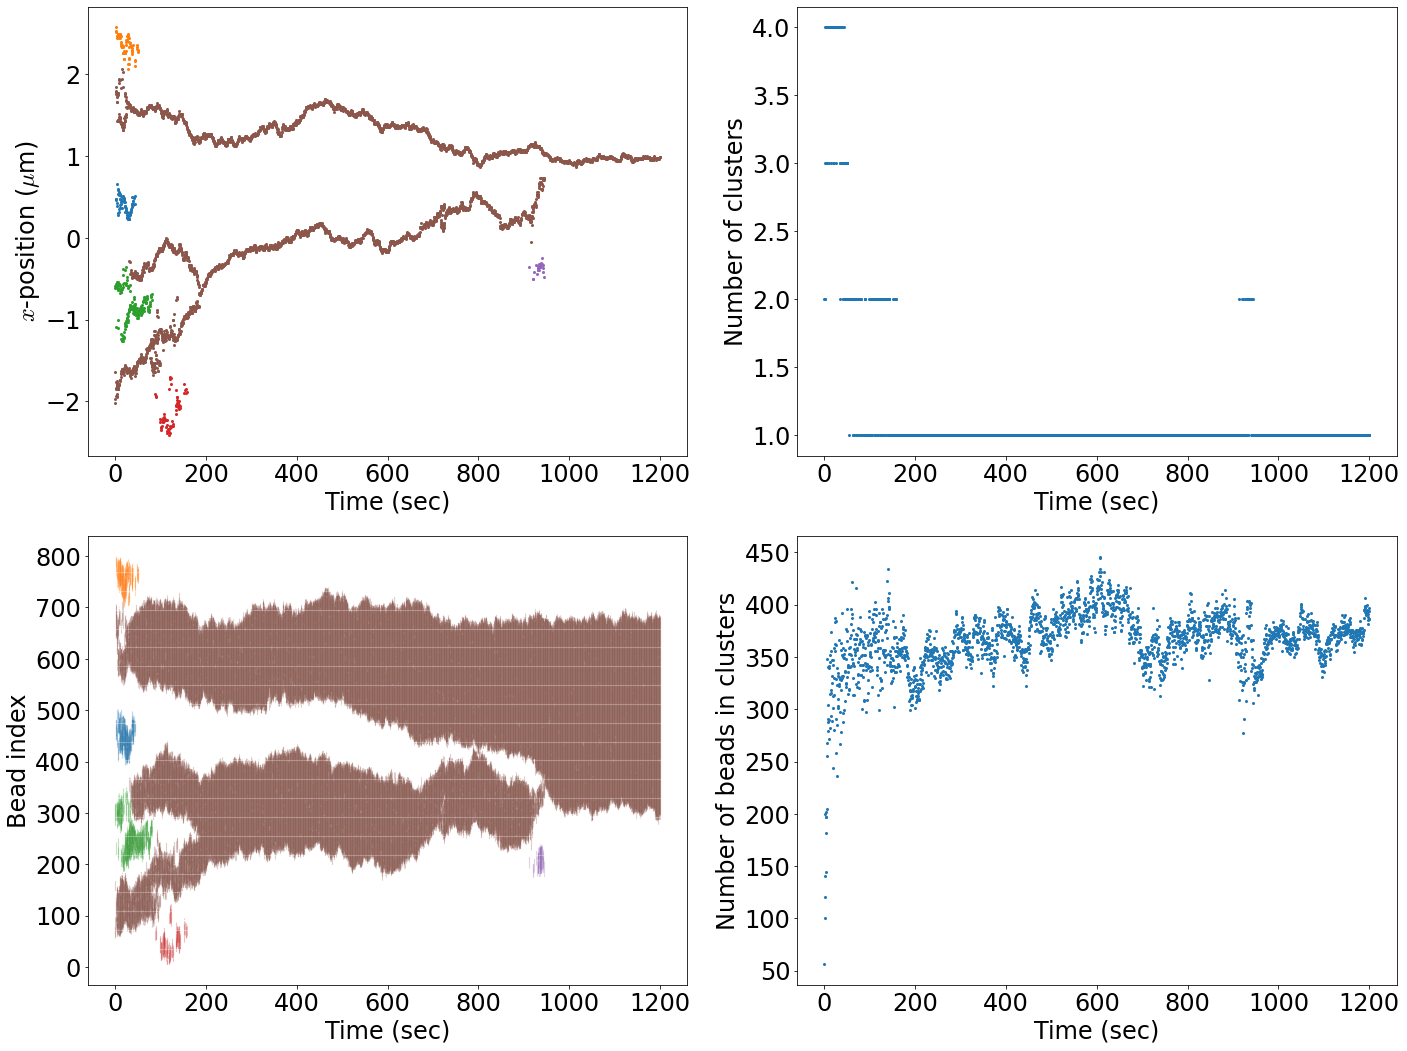

In [11]:
num_cluster_arr = np.zeros(time_arr.shape)
num_cluster_beads_arr = np.zeros(time_arr.shape)

fig, axarr = plt.subplots(2,2, figsize=(20, 15))
for tree in trees:
    if len(tree.clusters) < 20:
        continue
    time_lst = []
    flat_time_lst = []
    clust_ids = []
    clust_centers = []
    for clust in tree.clusters:

        t_idx = np.where(time_arr == clust.time)
        if clust.time not in time_lst:
            num_cluster_arr[t_idx] += 1
        num_cluster_beads_arr[t_idx] += len(clust.part_ids)

        time_lst += [clust.time]
        clust_centers += [clust.center]

        flat_time_lst += [clust.time]*len(clust.part_ids)
        clust_ids += clust.part_ids.tolist()
    _ = axarr[0,0].scatter(time_lst, np.array(clust_centers)[:,0])
    _ = axarr[1,0].scatter(flat_time_lst, clust_ids, s= .01, marker='.')

_ = axarr[0,1].scatter(time_arr, num_cluster_arr)
#axarr[1,0].scatter(flat_time_arr, flat_clust_ind_arr)
_ = axarr[1,1].scatter(time_arr, num_cluster_beads_arr)

_ = axarr[0,0].set_ylabel('$x$-position ($\mu$m)')
_ = axarr[0,1].set_ylabel('Number of clusters')
_ = axarr[1,0].set_ylabel('Bead index')
_ = axarr[1,1].set_ylabel('Number of beads in clusters')
for ax in axarr.flatten():
    _ = ax.set_xlabel('Time (sec)')
fig.tight_layout()

In [14]:
data_path = (ceph_path /"22-08-12_aLc1_scan8.12_line800_sticky55nm_ko.1-300_5umconf/simulations/kod0.1/s2")

# Length of chain and time to look at
ss_ind = 1
end_ind = None
start_bead = 0
end_bead = None

# Get bead position information
with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    print(time_arr.shape)
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

# Get cluster information
h5_clust_file = next(data_path.glob('analysis/cluster*.h5')) 
with h5py.File(h5_clust_file, 'r') as h5_data:
    cluster_grp = h5_data['clusters']
    time_arr = h5_data['time'][...]
    time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
    clusters = []
    for tg in time_grp_list:
        clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]

root_clusters = cla.find_descendants(clusters, thresh=.10, nskip=20)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree]

# for tree in trees:
for tree in filter(lambda x: len(x.clusters) > 20, trees):
    tree.prune_branches()

    

(2401,)
Nummber of roots to delete 6
Nummber of roots to delete 0
Nummber of roots to delete 0
Nummber of roots to delete 30
Nummber of roots to delete 0
Nummber of roots to delete 0
Nummber of roots to delete 17
Nummber of roots to delete 2
Nummber of roots to delete 1
Nummber of roots to delete 33
Nummber of roots to delete 71


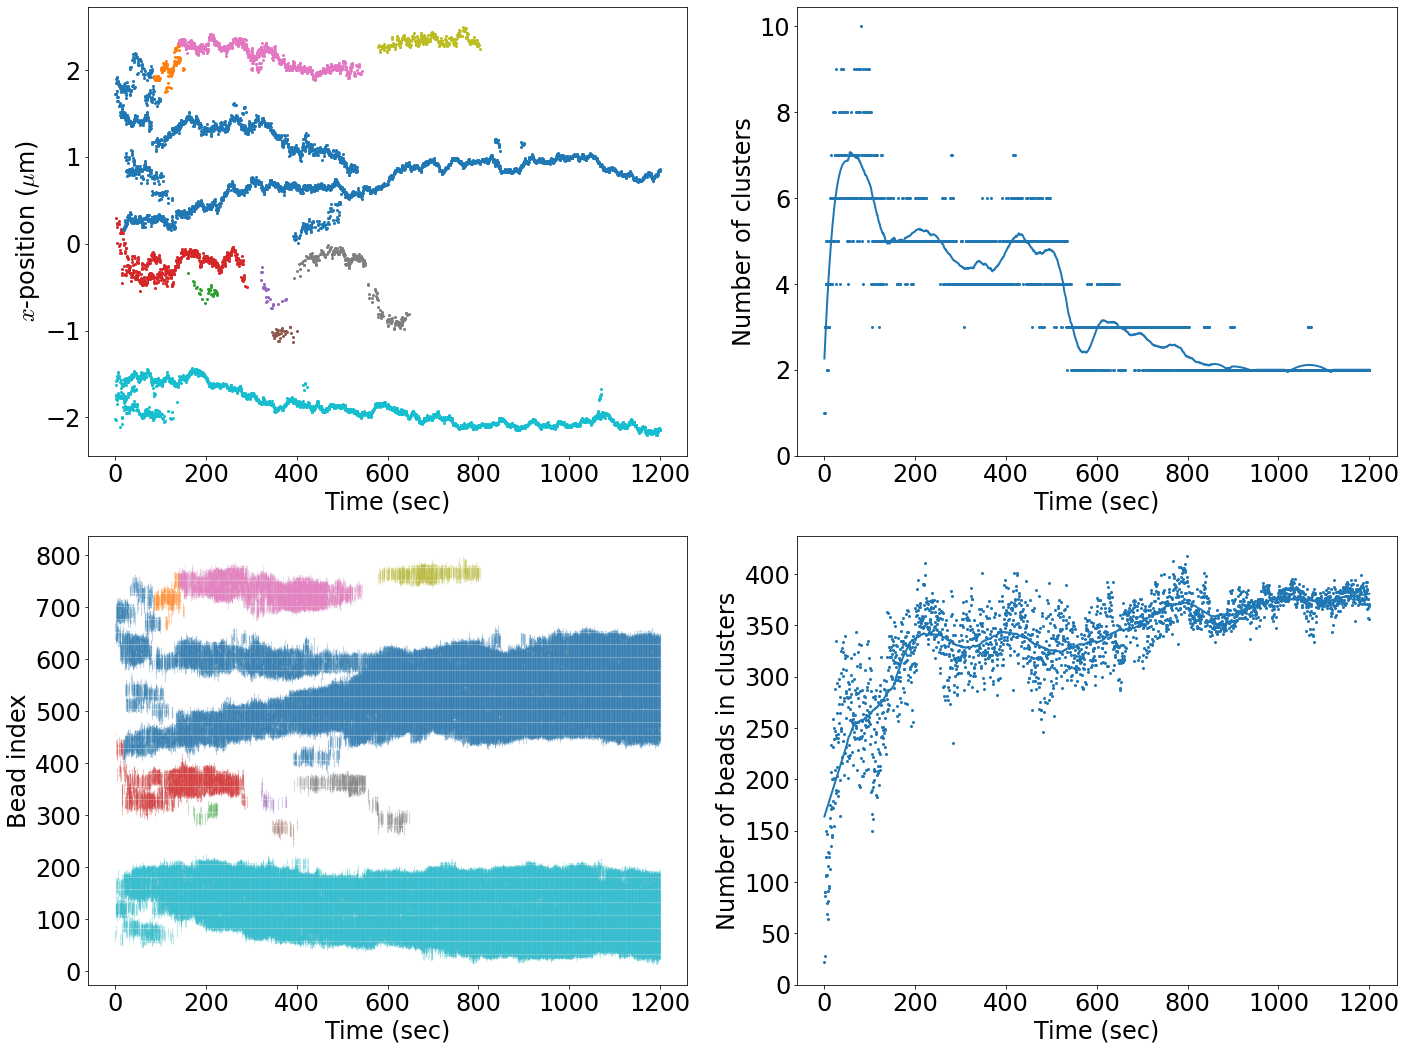

In [28]:
num_cluster_arr = np.zeros(time_arr.shape)
num_cluster_beads_arr = np.zeros(time_arr.shape)

fig, axarr = plt.subplots(2,2, figsize=(20, 15))
for tree in trees:
    if len(tree.clusters) < 20:
        continue
    time_lst = []
    flat_time_lst = []
    clust_ids = []
    clust_centers = []
    for clust in tree.clusters:

        t_idx = np.where(time_arr == clust.time)
        # if clust.time not in time_lst:
        num_cluster_arr[t_idx] += 1
        num_cluster_beads_arr[t_idx] += len(clust.part_ids)

        time_lst += [clust.time]
        clust_centers += [clust.center]

        flat_time_lst += [clust.time]*len(clust.part_ids)
        clust_ids += clust.part_ids.tolist()
    _ = axarr[0,0].scatter(time_lst, np.array(clust_centers)[:,0])
    _ = axarr[1,0].scatter(flat_time_lst, clust_ids, s= .01, marker='.')

_ = axarr[0,1].scatter(time_arr, num_cluster_arr)
_ = axarr[0,1].plot(time_arr, savgol_filter(num_cluster_arr, 201, 3))
_ = axarr[1,1].scatter(time_arr, num_cluster_beads_arr)
_ = axarr[1,1].plot(time_arr, savgol_filter(num_cluster_beads_arr, 201, 1))
_ = axarr[0, 1].set_ylim(0)
_ = axarr[1, 1].set_ylim(0)

_ = axarr[0,0].set_ylabel('$x$-position ($\mu$m)')
_ = axarr[0,1].set_ylabel('Number of clusters')
_ = axarr[1,0].set_ylabel('Bead index')
_ = axarr[1,1].set_ylabel('Number of beads in clusters')
for ax in axarr.flatten():
    _ = ax.set_xlabel('Time (sec)')
fig.tight_layout()

# Seed scan

/mnt/home/alamson/ceph/DATA/Chromatin/22-08-12_aLc1_scan8.12_line800_sticky55nm_ko.1-300_5umconf/simulations/kod100


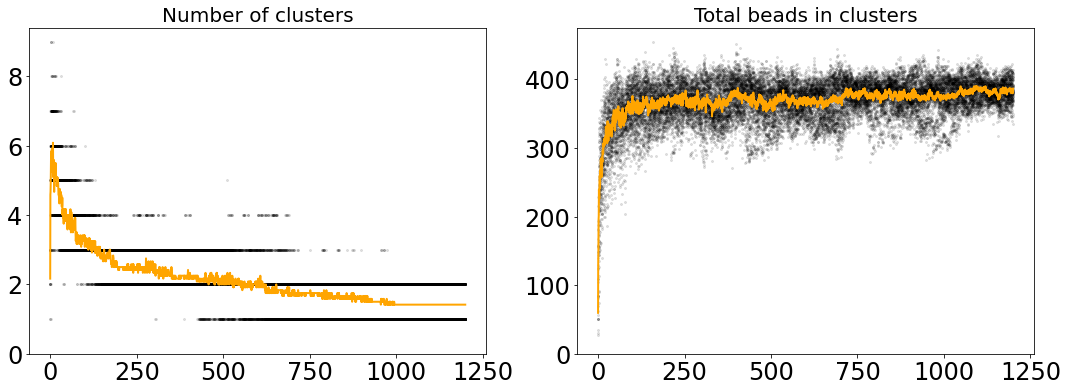

In [19]:
data_path = (ceph_path /"22-08-12_aLc1_scan8.12_line800_sticky55nm_ko.1-300_5umconf/simulations/kod100")
fig, axarr = plt.subplots(1,2, figsize=(18,6))
num_seeds = 0.
h5_data_lst = []
try:
    time_arr, avg_cluster_num, avg_total_bead  = get_sd_scan_cluster_num_and_bead_lst(data_path)
    for num_cluster_arr, num_cluster_beads_arr in zip(avg_cluster_num, avg_total_bead):
        _ = axarr[0].scatter(time_arr, num_cluster_arr, color='k',alpha=.1)
        # _ = axarr[2].plot(time_arr, savgol_filter(num_cluster_beads_arr, 201, 3), color='k',alpha=.1)
        _ = axarr[1].scatter(time_arr, num_cluster_beads_arr, color='k',alpha=.1)
    
        
    _ = axarr[0].plot(time_arr, np.array(avg_cluster_num).mean(axis=0), color='orange')
    _ = axarr[1].plot(time_arr, np.array(avg_total_bead).mean(axis=0), color='orange')
    
    _ = axarr[0].set_title('Number of clusters')
    _ = axarr[1].set_title('Total beads in clusters')

    _ = axarr[0].set_ylim(0)
    _ = axarr[1].set_ylim(0)
        
except:
    raise
finally:
    for h5d in h5_data_lst:
        h5d.close()

600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
492
486
486
489
491
487
492
492
491
493
485
490


/tmp/ipykernel_1113836/4068727748.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  avg_ee_arrs = np.array(avg_ee_arrs)


TypeError: unsupported operand type(s) for /: 'list' and 'int'

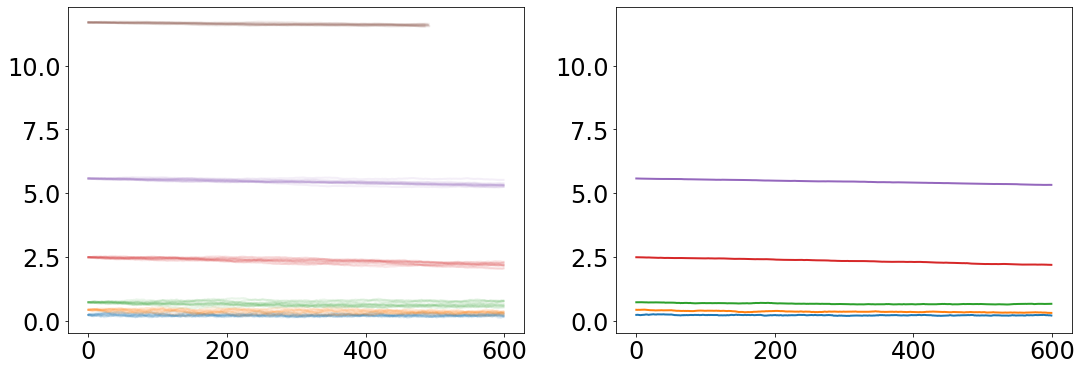

In [13]:
data_path = ceph_path / "22-08_aLc1_scan6.12_line200-6400_runs/simulations/"
colors = list(mcolors.TABLEAU_COLORS.keys())
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('line(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    
    ss_ind = 1
    end_ind = -1
    start_bead = 0
    end_bead = None


    avg_ee_list = []
    std_ee_list = []
    for i, pd in enumerate(param_dirs):
        avg_ee_arrs = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('simulations/s*/analysis/raw*.h5')]
        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][ss_ind:end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
           
            # ee_dist = aa.get_end_end_distance(com_arr)
            rog = aa.calc_rad_of_gyration(com_arr)
            _ = axarr1[0].plot(time_arr, rog, color=colors[i], alpha=.1)
            avg_ee_arrs += [rog.tolist()]
        
        avg_ee_arrs = np.array(avg_ee_arrs)
        avg_ee_list += [avg_ee_arrs.mean(axis=0)]
        std_ee_list += [avg_ee_arrs.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1[1].plot(time_arr, avg_ee_list[-1], color=colors[i], label=f"$L = {label}$ sec$^{{-1}}$")
        # _ = axarr1[1].plot(time_arr, avg_ee_list[-1][0]*np.exp(-float(label)*time_arr/np.sqrt(float(n_beads))), color=colors[i])
    
    # _ = axarr1[0].set_ylim(0.1)
    
    _ = axarr1[0].set_ylabel('Radius of gyration\n' + r'$R_g$ ($\mu$m)')
    _ = axarr1[0].set_xlabel('Time (sec)')
    _ = axarr1[1].set_xlabel('Time (sec)')
    _ = axarr1[0].set_yscale('log')
    # _ = axarr1[0].set_ylim(0.1)

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

# Param-seed scan

In [8]:
data_path = (ceph_path /"22-08-12_aLc1_scan8.12_line800_sticky55nm_ko.1-300_5umconf")

param_paths = [path for path in data_path.glob('simulations/kod*/') if path.is_dir()]
for pp in param_paths:
    anal_path = data_path /f'analysis/{pp.name}'
    anal_path.mkdir(exist_ok=True)
    with h5py.File(anal_path / f'{pp.name}_sd_scan.h5', 'w') as h5_data:
        time_arr, seed_cluster_num, seed_total_bead  = get_sd_scan_cluster_num_and_bead_lst(pp)
        _ = h5_data.create_dataset('time', data=time_arr)
        _ = h5_data.create_dataset('sd_cluster_num', data=seed_cluster_num)
        _ = h5_data.create_dataset('sd_total_cluster_bead_num', data=seed_total_bead)





kod1
/mnt/home/alamson/ceph/DATA/Chromatin/22-08-12_aLc1_scan8.12_line800_sticky55nm_ko.1-300_5umconf/simulations/kod1
kod0.1
/mnt/home/alamson/ceph/DATA/Chromatin/22-08-12_aLc1_scan8.12_line800_sticky55nm_ko.1-300_5umconf/simulations/kod0.1
kod100
/mnt/home/alamson/ceph/DATA/Chromatin/22-08-12_aLc1_scan8.12_line800_sticky55nm_ko.1-300_5umconf/simulations/kod100
kod3
/mnt/home/alamson/ceph/DATA/Chromatin/22-08-12_aLc1_scan8.12_line800_sticky55nm_ko.1-300_5umconf/simulations/kod3
kod30
/mnt/home/alamson/ceph/DATA/Chromatin/22-08-12_aLc1_scan8.12_line800_sticky55nm_ko.1-300_5umconf/simulations/kod30
kod300
/mnt/home/alamson/ceph/DATA/Chromatin/22-08-12_aLc1_scan8.12_line800_sticky55nm_ko.1-300_5umconf/simulations/kod300
kod0.3
/mnt/home/alamson/ceph/DATA/Chromatin/22-08-12_aLc1_scan8.12_line800_sticky55nm_ko.1-300_5umconf/simulations/kod0.3
kod10
/mnt/home/alamson/ceph/DATA/Chromatin/22-08-12_aLc1_scan8.12_line800_sticky55nm_ko.1-300_5umconf/simulations/kod10


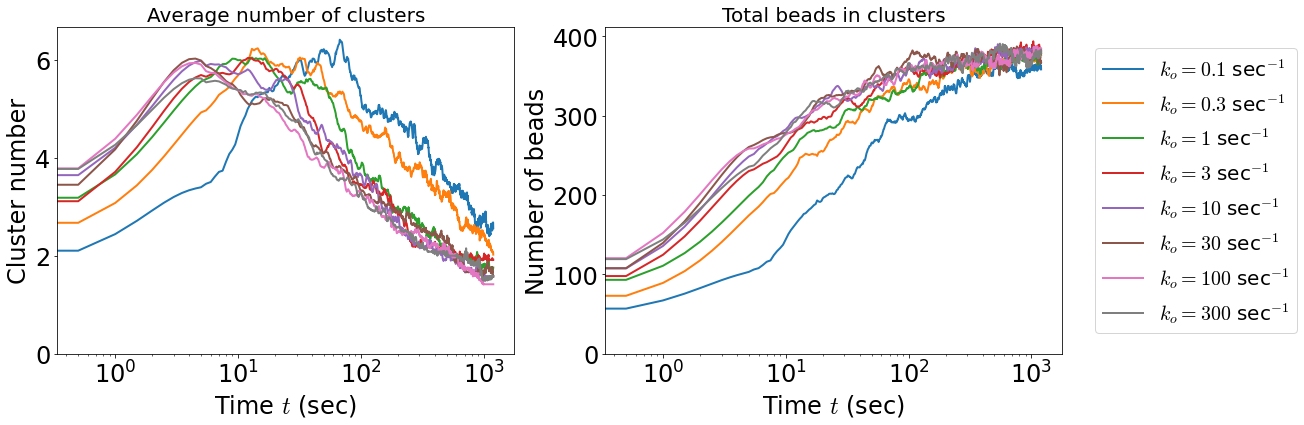

In [25]:
data_path = (ceph_path /"22-08-12_aLc1_scan8.12_line800_sticky55nm_ko.1-300_5umconf/analysis")
fig, axarr = plt.subplots(1,2, figsize=(18,6))
mp = re.compile('kod(\d*\.?\d+)')

param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
for pdir in param_dirs:
    with h5py.File(next(pdir.glob('*sd_scan.h5')), 'r') as h5_data:
        time_arr = h5_data['time'][...]
        sd_cluster_num = h5_data['sd_cluster_num'][...]
        sd_total_cluster_bead_num = h5_data['sd_total_cluster_bead_num'][...]
        label = re.split(r'(^[^\d]+)',str(pdir.name))[1:][1]
    
    
        
    _ = axarr[0].plot(time_arr, savgol_filter(np.array(sd_cluster_num).mean(axis=0), 21, 3))
    # _ = axarr[1].plot(time_arr, np.array(sd_total_cluster_bead_num).mean(axis=0), label=f"$k_o = {label}$ sec$^{{-1}}$")
    _ = axarr[1].plot(time_arr, savgol_filter(np.array(sd_total_cluster_bead_num).mean(axis=0), 21, 3), label=f"$k_o = {label}$ sec$^{{-1}}$")

_ = axarr[0].set_title('Average number of clusters')
_ = axarr[1].set_title('Total beads in clusters')

_ = axarr[0].set_ylabel('Cluster number')
_ = axarr[1].set_ylabel('Number of beads')


for ax in axarr:
    _ = ax.set_xscale('log')
    _ = ax.set_ylim(0)
    _ = ax.set_xlabel('Time $t$ (sec)')
_ = axarr[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))


# Cluster size

One way edge found for cond 5
One way edge found for cond 2
One way edge found for cond 11


(0.0, 5.587906563282013)

(0.0, 342.2)

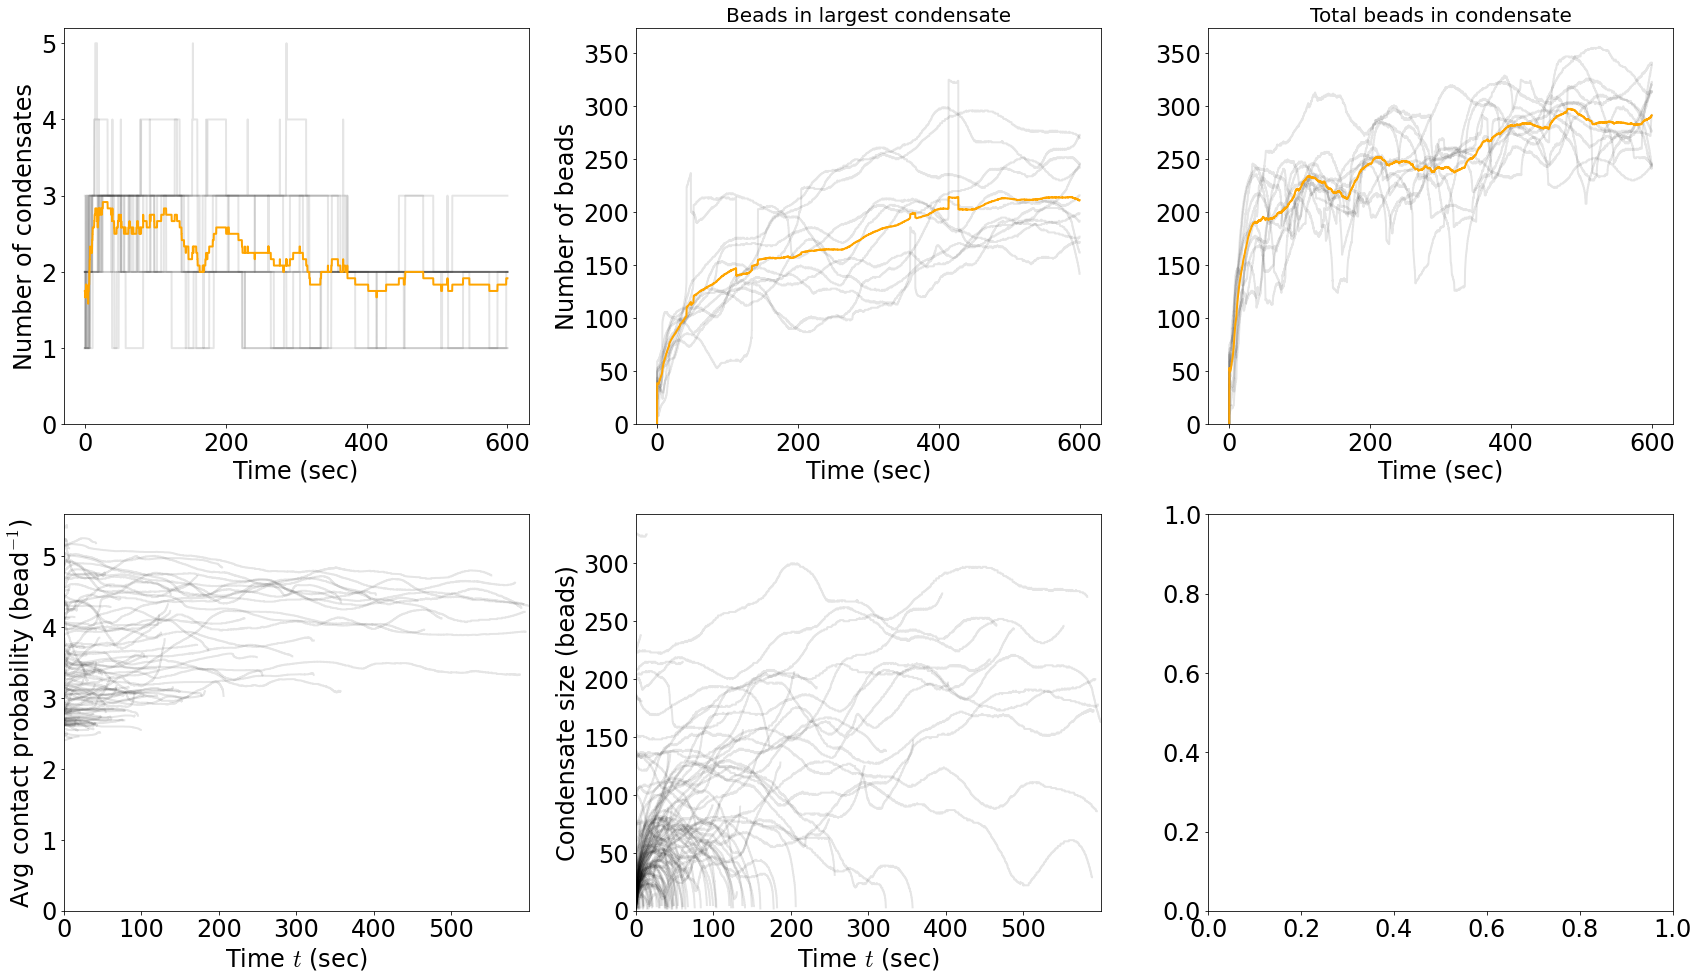

In [5]:
data_path = ceph_path / "21-11-30_aLchr1_scan.12_line700_2xsticky_conf/simulations/"
ss_ind = 1
fig, axarr = plt.subplots(2,3, figsize=(24,14))
#axarr[1].sharey(axarr[2])
avg_cond_num = None
avg_max_width = None
avg_total_bead = None
num_seeds = 0.
h5_data_lst = []
try:
#     for h5_path in data_path.glob('**/*.h5'):
#         with h5py.File(h5_path, 'r+') as h5d:
#             print(h5_path)
    
    sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in data_path.glob('s*/analysis/*.h5')]
    sd_h5_data_lst.sort(key=aa.sd_num)
    ss_ind = sd_h5_data_lst[0]['analysis/pos_kymo'].attrs['timestep_range'][0]
    end_ind = sd_h5_data_lst[0]['analysis/pos_kymo'].attrs['timestep_range'][1]
    time_arr = sd_h5_data_lst[0]['time'][ss_ind:end_ind]
    # TODO: Cludge - make this better
    start_bead = 0
    end_bead = None
    nbeads = sd_h5_data_lst[0]['raw_data']['sylinders'][start_bead:end_bead, 0, 0].shape[0]
    
    cond_num_arr, max_width_arr, total_bead_arr = aa.get_scan_cond_data(
        sd_h5_data_lst)
    aa.plot_condensate_num_sd_scan(axarr[0,0], time_arr, cond_num_arr)
    aa.plot_condensate_size_sd_scan(
        axarr[0,1:], time_arr, max_width_arr, total_bead_arr)
    
    for h5_data in sd_h5_data_lst:
        analysis_grp = h5_data['analysis']

        contact_kymo = analysis_grp['contact_kymo'][...]
        nbeads = contact_kymo.shape[0]
        contact_cond_edges = analysis_grp['contact_cond_edges'][...]
        contact_cond_num = analysis_grp['contact_cond_num'][...]

        stored_condensates = aa.gen_condensate_track_info(time_arr, contact_cond_edges, contact_cond_num) 
        aa.plot_condensate_avg_contact_vs_time(axarr[1,0], time_arr, contact_kymo, stored_condensates,
                                        same_start_flag=True, color='k', alpha=.1)
        aa.plot_condensate_size_vs_time(axarr[1,1], time_arr, stored_condensates, same_start_flag=True, color='k', alpha=.1)
    axarr[1,0].set_ylim(0)
    axarr[1,1].set_ylim(0)

    fig.tight_layout()
except:
    raise
finally:
    for h5d in h5_data_lst:
        h5d.close()

Super merging event occured at cond 5
One way edge found for cond 13


(0.0, 5.431228077411651)

(0.0, 319.1)

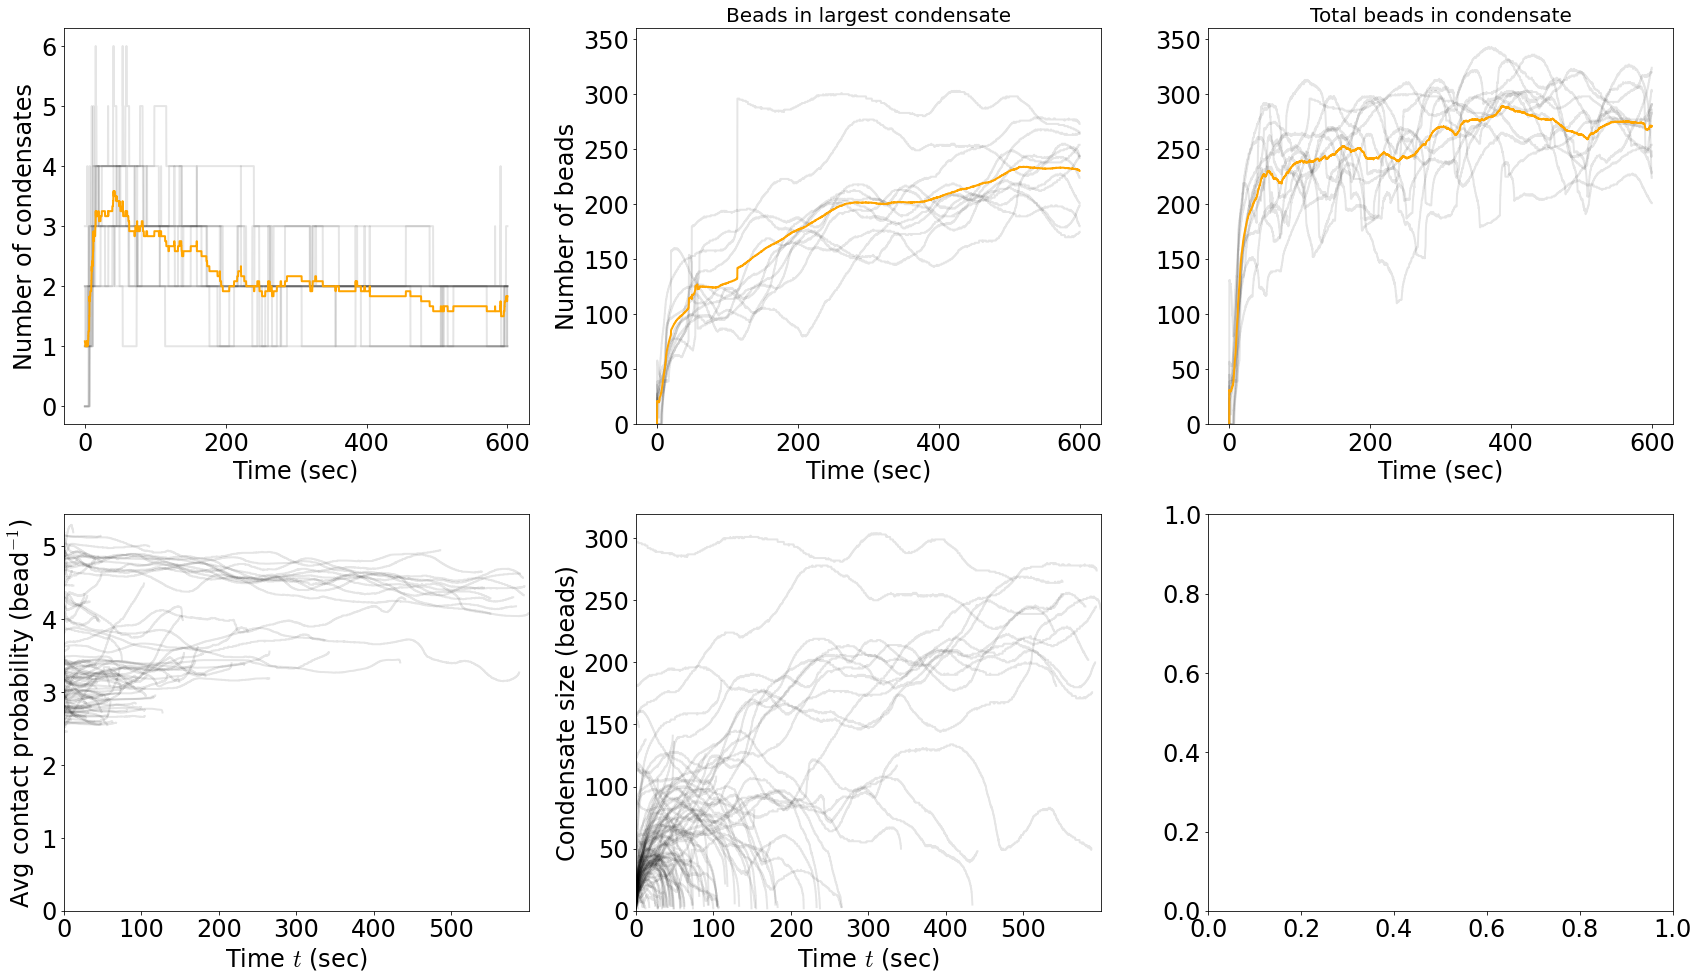

In [126]:
data_path = ceph_path / "21-12-05_aLchr1_scan.12_line700_2xsticky_rigid20_conf/simulations"
ss_ind = 1
fig, axarr = plt.subplots(2,3, figsize=(24,14))
#axarr[1].sharey(axarr[2])
avg_cond_num = None
avg_max_width = None
avg_total_bead = None
num_seeds = 0.
h5_data_lst = []
try:
#     for h5_path in data_path.glob('**/*.h5'):
#         with h5py.File(h5_path, 'r+') as h5d:
#             print(h5_path)
    
    sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in data_path.glob('s*/analysis/*.h5')]
    sd_h5_data_lst.sort(key=aa.sd_num)
    ss_ind = sd_h5_data_lst[0]['analysis/pos_kymo'].attrs['timestep_range'][0]
    end_ind = sd_h5_data_lst[0]['analysis/pos_kymo'].attrs['timestep_range'][1]
    time_arr = sd_h5_data_lst[0]['time'][ss_ind:end_ind]
    # TODO: Cludge - make this better
    start_bead = 0
    end_bead = None
    nbeads = sd_h5_data_lst[0]['raw_data']['sylinders'][start_bead:end_bead, 0, 0].shape[0]
    
    cond_num_arr, max_width_arr, total_bead_arr = aa.get_scan_cond_data(
        sd_h5_data_lst)
    aa.plot_condensate_num_sd_scan(axarr[0,0], time_arr, cond_num_arr)
    aa.plot_condensate_size_sd_scan(
        axarr[0,1:], time_arr, max_width_arr, total_bead_arr)
    
    for h5_data in sd_h5_data_lst:
        analysis_grp = h5_data['analysis']

        contact_kymo = analysis_grp['contact_kymo'][...]
        nbeads = contact_kymo.shape[0]
        contact_cond_edges = analysis_grp['contact_cond_edges'][...]

        stored_condensates = aa.gen_condensate_track_info(h5_data) 
        aa.plot_condensate_avg_contact_vs_time(axarr[1,0], time_arr, contact_kymo, stored_condensates,
                                        same_start_flag=True, color='k', alpha=.1)
        aa.plot_condensate_size_vs_time(axarr[1,1], time_arr, stored_condensates, same_start_flag=True, color='k', alpha=.1)
    
    axarr[1,0].set_ylim(0)
    axarr[1,1].set_ylim(0)

    fig.tight_layout()
except:
    raise
finally:
    for h5d in h5_data_lst:
        h5d.close()

/mnt/home/alamson/projects/analysis/AMSOS_Analysis/alens_analysis/chrom_seed_scan_analysis.py:95: RuntimeWarning: divide by zero encountered in log
  return log_avg_contact_mat


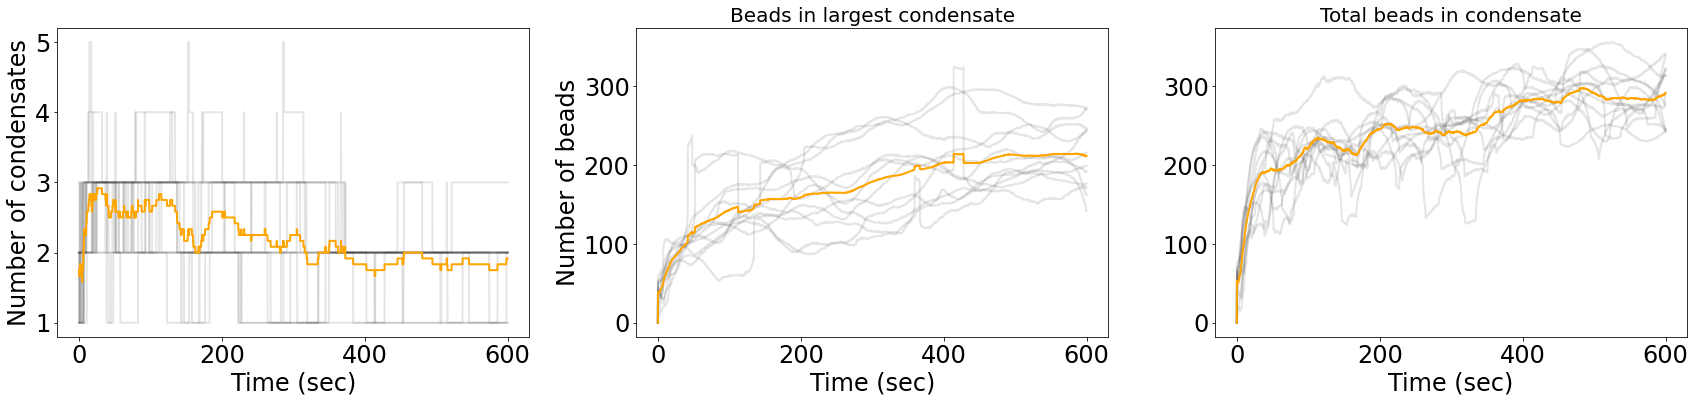

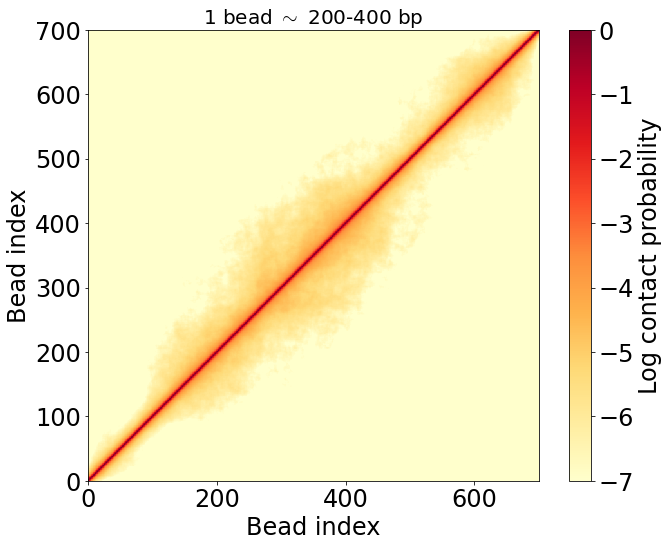

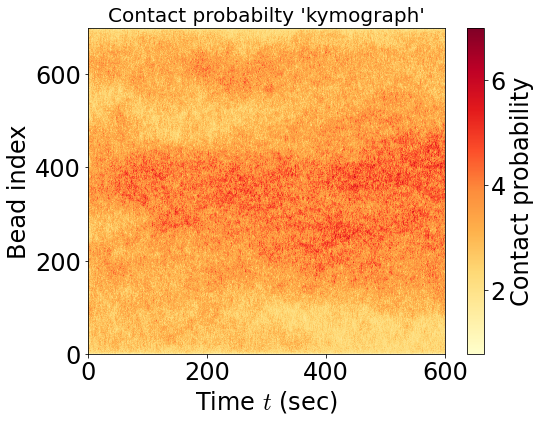

In [80]:
data_path = ceph_path / "21-11-30_aLchr1_scan.12_line700_2xsticky_conf/simulations/"

try:
    sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in data_path.glob('s*/analysis/*.h5')]
    ss_ind = sd_h5_data_lst[0]['analysis/pos_kymo'].attrs['timestep_range'][0]
    end_ind = sd_h5_data_lst[0]['analysis/pos_kymo'].attrs['timestep_range'][1]
    time_arr = sd_h5_data_lst[0]['time'][ss_ind:end_ind]
    start_bead = 0
    end_bead = None
    nbeads = sd_h5_data_lst[0]['raw_data']['sylinders'][start_bead:end_bead, 0, 0].shape[0]

    fig1, axarr1 = plt.subplots(1, 3, figsize=(24, 6))
    cond_num_arr, max_width_arr, total_bead_arr = aa.get_scan_cond_data(sd_h5_data_lst)
    
    aa.plot_condensate_num_sd_scan(axarr1[0], time_arr, cond_num_arr)
    aa.plot_condensate_size_sd_scan(axarr1[1:], time_arr, max_width_arr, total_bead_arr)
    fig1.tight_layout()
    
    log_avg_contact_mat = aa.get_scan_avg_contact_mat(sd_h5_data_lst)
    fig2, ax2 = aa.make_hic_plot(nbeads, log_avg_contact_mat, vmin=-7.)
    
    fig3, ax3 = plt.subplots(figsize=(8, 6))
    avg_contact_kymo = aa.get_scan_avg_kymo(sd_h5_data_lst)
    aa.plot_contact_kymo(fig3, ax3, time_arr, avg_contact_kymo, vmax=7.)
    #fig, ax = aa.make_hic_plot(com_arr, log_avg_contact_mat/num_seeds, vmin=-7.)
except:
    raise
finally:
    for h5d in h5_data_lst:
        h5d.close()

## Average run tests

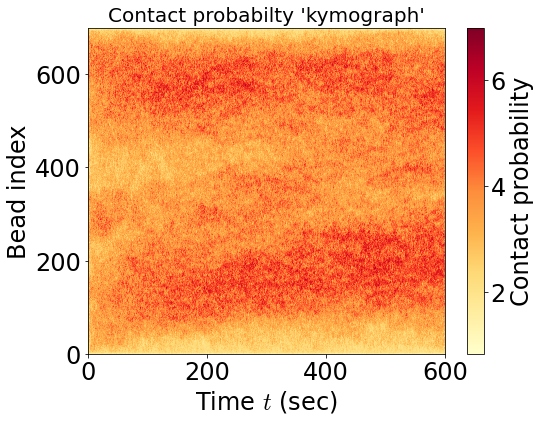

In [10]:
data_path = ceph_path / "21-12-05_aLchr1_scan.12_line700_2xsticky_3umconf/simulations/"
ss_ind = 0
fig, ax = plt.subplots(figsize=(8,6))
avg_contact_kymo = None
num_seeds = 0.
h5_data_lst = []

try:
    for h5_path in data_path.glob('s*/analysis/*.h5'):
        h5_data_lst += [h5py.File(h5_path, 'r+')]
    for h5d in h5_data_lst:
        if avg_contact_kymo is None:
            time_arr = h5d['time'][1:-1]
            avg_contact_kymo = h5d['analysis']['contact_kymo'][...]
        else:
            avg_contact_kymo += h5d['analysis']['contact_kymo'][...]
        num_seeds += 1.
        
    aa.plot_contact_kymo(fig, ax, time_arr, avg_contact_kymo/num_seeds, vmax=7.)
except:
    raise
finally:
    for h5d in h5_data_lst:
        h5d.close()

# Conclusions and Next Steps